In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data loading function
def load_qr_code_dataset(dataset_path):
    """
    Load QR code images and create a structured dataset

    Args:
        dataset_path (str): Path to the dataset directory

    Returns:
        tuple: (images, labels, metadata)
    """
    images = []
    labels = []
    metadata = []

    # Assuming subdirectories 'first_print' and 'second_print'
    for category in ['first_print', 'second_print']:
        category_path = os.path.join(dataset_path, category)
        for image_filename in os.listdir(category_path):
            image_path = os.path.join(category_path, image_filename)

            # Load and preprocess image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (224, 224))  # Standardize image size

            images.append(image)
            labels.append(category)

            # Collect metadata
            metadata.append({
                'filename': image_filename,
                'category': category,
                'filesize': os.path.getsize(image_path)
            })

    return np.array(images), np.array(labels), pd.DataFrame(metadata)

In [ ]:
def analyze_dataset(images, labels, metadata):
    """
    Perform comprehensive dataset analysis

    Args:
        images (np.array): Image dataset
        labels (np.array): Image labels
        metadata (pd.DataFrame): Image metadata
    """
    # Basic statistics
    print("Dataset Composition:")
    print(pd.Series(labels).value_counts())

    # Visualize image characteristics
    plt.figure(figsize=(15, 5))

    # Pixel intensity distribution
    plt.subplot(131)
    plt.title("Pixel Intensity Distribution")
    for category in ['first_print', 'second_print']:
        category_images = images[labels == category]
        sns.histplot(category_images.ravel(), label=category, kde=True)
    plt.legend()

    # Image size variation
    plt.subplot(132)
    plt.title("File Size Distribution")
    sns.boxplot(x=labels, y=metadata['filesize'])

    # Image entropy analysis
    plt.subplot(133)
    plt.title("Image Entropy")
    entropies = [shannon_entropy(img) for img in images]
    sns.boxplot(x=labels, y=entropies)

    plt.tight_layout()
    plt.show()

def shannon_entropy(image):
    """Calculate Shannon entropy of an image"""
    _, counts = np.unique(image, return_counts=True)
    probabilities = counts / np.sum(counts)
    return -np.sum(probabilities * np.log2(probabilities))

In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops

def extract_advanced_features(images):
    """
    Extract comprehensive features from QR code images

    Args:
        images (np.array): Input images

    Returns:
        np.array: Feature matrix
    """
    features = []

    for image in images:
        # Ensure grayscale
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Normalize image
        image = image.astype(np.float32) / 255.0

        # Texture features
        lbp = local_binary_pattern(image, P=8, R=1, method='uniform')

        # Prepare image for GLCM (needs uint8)
        glcm_image = (image * 255).astype(np.uint8)
        glcm = graycomatrix(glcm_image, [1], [0], levels=256, symmetric=True, normed=True)

        feature_vector = [
            # Statistical features
            np.mean(image),
            np.std(image),
            skew(image.ravel()),
            kurtosis(image.ravel()),

            # Entropy
            shannon_entropy(image),

            # Texture features
            np.mean(lbp),
            np.std(lbp),

            # GLCM features
            graycoprops(glcm, 'contrast')[0,0],
            graycoprops(glcm, 'dissimilarity')[0,0],
            graycoprops(glcm, 'homogeneity')[0,0],
            graycoprops(glcm, 'energy')[0,0],
            graycoprops(glcm, 'correlation')[0,0],
        ]

        features.append(feature_vector)

    return np.array(features)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

def create_qr_cnn_model(input_shape=(224, 224, 1)):
    """
    Create a Convolutional Neural Network for QR code classification

    Args:
        input_shape (tuple): Input image dimensions

    Returns:
        tf.keras.Model: Compiled CNN model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and fully connected layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc
)

def evaluate_model(y_true, y_pred, y_pred_proba):
    """
    Comprehensive model evaluation

    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        y_pred_proba (array): Predicted probabilities
    """
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.show()

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5344 - loss: 51.6638 - precision: 0.4480 - recall: 0.4210 - val_accuracy: 0.6250 - val_loss: 1.4264 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5906 - loss: 34.0750 - precision: 0.5464 - recall: 0.9355 - val_accuracy: 0.3750 - val_loss: 6.7986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6854 - loss: 8.8986 - precision: 0.9317 - recall: 0.3829 - val_accuracy: 0.3750 - val_loss: 8.3498 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8760 - loss: 3.8307 - precision: 0.7917 - recall: 0.9891 - val_accuracy: 0.3750 - val_loss: 13.0532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9198 - loss: 1.9989 - precision: 0.8717 - recall: 0.9752 - val_accuracy: 0.3750 -

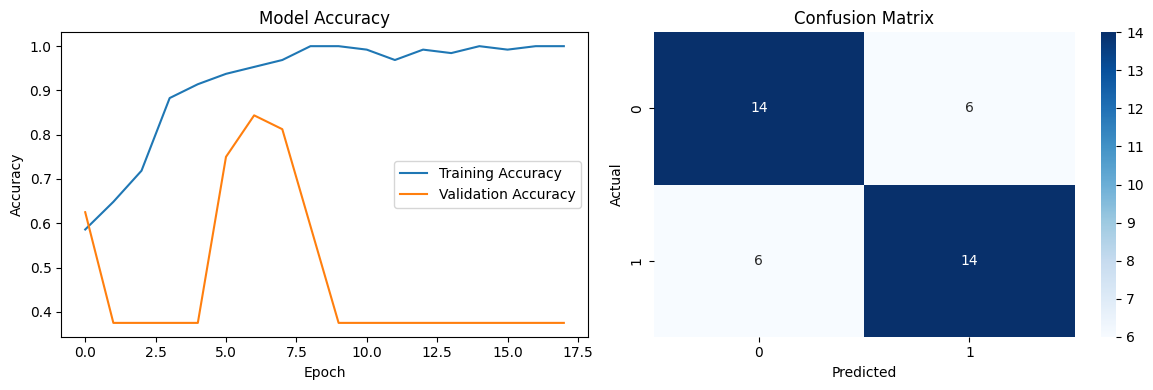


Detailed Classification Report:
              precision  recall  f1-score  support
0                   0.7     0.7       0.7     20.0
1                   0.7     0.7       0.7     20.0
accuracy            0.7     0.7       0.7      0.7
macro avg           0.7     0.7       0.7     40.0
weighted avg        0.7     0.7       0.7     40.0


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Data Loading Function
def load_qr_code_dataset(dataset_path):
    """
    Load QR code images from a directory

    Args:
        dataset_path (str): Path to the dataset directory

    Returns:
        tuple: (X, y, filenames)
    """
    images = []
    labels = []
    filenames = []

    # Assuming binary classification folders
    classes = ['first_prints', 'second_prints']

    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)

        # Ensure the path exists
        if not os.path.exists(class_path):
            raise ValueError(f"Directory not found: {class_path}")

        # Iterate through images in the class folder
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Read image and preprocess
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Resize to a consistent size
            img = cv2.resize(img, (224, 224))

            # Normalize pixel values
            img = img / 255.0

            images.append(img)
            labels.append(label)
            filenames.append(filename)

    return (
        np.array(images)[..., np.newaxis],  # Add channel dimension for CNN
        np.array(labels),
        np.array(filenames)
    )

# Feature Extraction Function
def extract_advanced_features(images):
    """
    Extract advanced features from images

    Args:
        images (np.array): Input images

    Returns:
        np.array: Extracted features
    """
    from skimage.feature import local_binary_pattern
    from skimage.measure import shannon_entropy
    from scipy.stats import skew, kurtosis

    features = []

    for image in images:
        # Squeeze to remove channel dimension if needed
        image = image.squeeze()

        # Texture features
        lbp = local_binary_pattern(image, P=8, R=1, method='uniform')

        feature_vector = [
            # Statistical features
            np.mean(image),
            np.std(image),
            skew(image.ravel()),
            kurtosis(image.ravel()),

            # Entropy
            shannon_entropy(image),

            # Texture features
            np.mean(lbp),
            np.std(lbp)
        ]

        features.append(feature_vector)

    return np.array(features)

# CNN Model Architecture
def create_qr_cnn_model(input_shape=(224, 224, 1)):
    """
    Create a Convolutional Neural Network for QR code classification

    Args:
        input_shape (tuple): Input image dimensions

    Returns:
        tf.keras.Model: Compiled CNN model
    """
    model = tf.keras.Sequential([
        # Convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten and fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Main Training and Evaluation Function
def train_and_evaluate_qr_code_classifier(dataset_path):
    """
    Complete workflow for QR code classification

    Args:
        dataset_path (str): Path to the dataset

    Returns:
        dict: Model performance metrics
    """
    # 1. Load Dataset
    X, y, filenames = load_qr_code_dataset(dataset_path)

    # 2. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Extract Features (Optional - you can use raw images for CNN)
    X_train_features = extract_advanced_features(X_train)
    X_test_features = extract_advanced_features(X_test)

    # 4. Scale Features
    scaler = StandardScaler()
    X_train_features_scaled = scaler.fit_transform(X_train_features)
    X_test_features_scaled = scaler.transform(X_test_features)

    # 5. Create and Train CNN Model
    model = create_qr_cnn_model()

    # Early stopping and model checkpointing
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping]
    )

    # 6. Evaluate the Model
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # 7. Visualize Results
    plt.figure(figsize=(12, 4))

    # Training History
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 8. Return Performance Metrics
    return {
        'classification_report': report,
        'confusion_matrix': cm,
        'model': model
    }

# Main Execution
if __name__ == '__main__':
    # Replace with your actual dataset path
    DATASET_PATH = '/content/drive/MyDrive/qrproject'

    try:
        # Run the full classification workflow
        results = train_and_evaluate_qr_code_classifier(DATASET_PATH)

        # Print detailed classification report
        print("\nDetailed Classification Report:")
        print(pd.DataFrame(results['classification_report']).transpose())

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check your dataset path and ensure images are correctly formatted.")